<a href="https://colab.research.google.com/github/StefanieSun20/VMESS/blob/main/stable_diffusion_%E8%87%AA%E5%8A%A8%E8%AF%86%E5%88%ABCPUorGPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Stable Diffusion** 🎨 

In [ ]:
#@title 自动识别 GPU or CPU 模式

!nvidia-smi > GPUtext
f = open("GPUtext","r")
GPUlines = f.readlines()
# GPU状态返回值大于0则为GPU模式
if len(GPUlines)>0:
  print(">0")
  torch_type = torch.float16
  GPU = 1
else:
  print("<=0")
  !pip install torch==2.0.1+cpu torchvision==0.15.2+cpu torchaudio==2.0.2 --index-url https://download.pytorch.org/whl/cpu
  torch_type = torch.float32
  GPU = 0

#共性环境安装
!pip install diffusers==0.11.1
!pip install transformers scipy ftfy accelerate
import torch
from diffusers import StableDiffusionPipeline

#pipe = StableDiffusionPipeline.from_pretrained(, torch_dtype=torch.float16)
model_id = "stablediffusionapi/chilloutmix"
#其他模型： runwayml/stable-diffusion-v1-5  #"stabilityai/stable-diffusion-2-1"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch_type)  
pipe.safety_checker = lambda images, clip_input: (images, False)
n=1
if GPU>0:
  pipe = pipe.to("cuda")

In [ ]:
#@title 启用图片放大
from diffusers import StableDiffusionUpscalePipeline
 
# load model and scheduler
if not exist(torch_type):
  torch_type = torch.float16
model_scale = "stabilityai/stable-diffusion-x4-upscaler"
pipe_upscale = StableDiffusionUpscalePipeline.from_pretrained(model_scale, torch_dtype=torch_type, cache_dir="./models/")
if GPU>0:
  pipe_upscale = pipe_upscale.to("cuda")


In [ ]:
#@title 启用改图
import torch
from diffusers import StableDiffusionInpaintPipeline
import requests
from PIL import Image
from io import BytesIO

if not exist(torch_type):
  torch_type = torch.float16
pipe_change = StableDiffusionInpaintPipeline.from_pretrained("runwayml/stable-diffusion-inpainting", torch_dtype=torch_type)
pipe_change.safety_checker = lambda images, clip_input: (images, False)
if GPU>0:
  pipe_change = pipe_change.to("cuda")

def show_images(imgs, rows=1, cols=3):
    assert len(imgs) == rows*cols
    w_ori, h_ori = imgs[0].size
    for img in imgs:
        w_new, h_new = img.size
        if w_new != w_ori or h_new != h_ori:
            w_ori = max(w_ori, w_new)
            h_ori = max(h_ori, h_new)
    
    grid = Image.new('RGB', size=(cols*w_ori, rows*h_ori))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w_ori, i//cols*h_ori))
    return grid
 
def download_image(url):
    response = requests.get(url)
    return Image.open(BytesIO(response.content)).convert("RGB")


  0%|          | 0/50 [00:00<?, ?it/s]

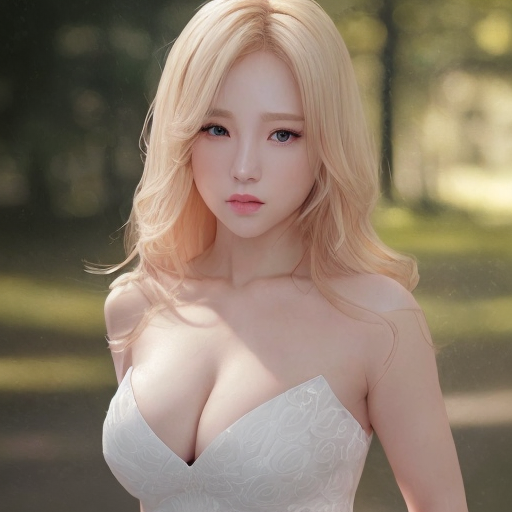

In [ ]:
#@title 创作--文生图
prompt = "8k,outdoors,full body,((a sophisticated sense of style)),(aegyo sal:1),wide shoulders,blush,blond hair,atmospheric perspective,professional light, intricate detail, highres, detailed facial features, high detail, sharp focus, smooth, aesthetic, extremely detailed, stamp, octane render,{{{masterpiece}}}"
#prompt = "palying pussy,detailed pussy,nfsw,blond hair,{steam},Looking at Viewer,morning,atmospheric perspective,bokeh,detailed,Cinematic light, intricate detail, highres, detailed facial features, high detail, sharp focus, smooth, aesthetic, extremely detailed, stamp, octane render,{{{masterpiece}}}
#prompt ="a logo,watermelon,extremely simple,watercolor ink,chinese style,only black lines"
#image1 = pipe(prompt).images[0]  # image here is in [PIL format](https://pillow.readthedocs.io/en/stable/)

#设置图像大小
#image1 = pipe(prompt, height=512, width=512).images[0]

#设置具体参数
image1 = pipe(prompt, num_inference_steps=50, guidance_scale=7).images[0]

#显示生成的图像
image1

  0%|          | 0/50 [00:00<?, ?it/s]

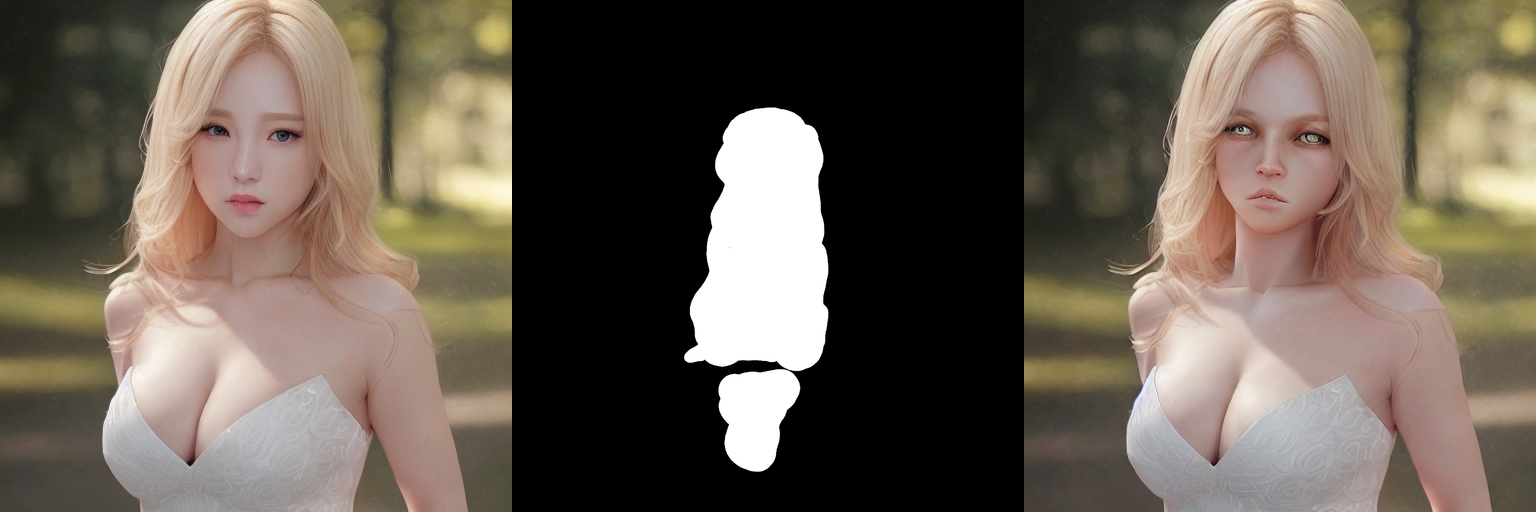

In [ ]:
#@title 创作--改图
img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"
 
init_image = download_image(img_url).resize((512, 512))
mask_image = download_image(mask_url).resize((512, 512))
init_image = image1.resize((512, 512))

prompt = "palying pussy,detailed pussy,nfsw,blond hair,{steam},Looking at Viewer,morning,atmospheric perspective,bokeh,detailed,Cinematic light, intricate detail, highres, detailed facial features, high detail, sharp focus, smooth, aesthetic, extremely detailed, stamp, octane render,{{{masterpiece}}}"
imageN = pipe_change(prompt=prompt, image=init_image, mask_image=mask_image).images
grid_img = show_images([init_image, mask_image, imageN[0]], 1, 3)
grid_img
#grid_img.save("overture-creations.png")


  0%|          | 0/75 [00:00<?, ?it/s]

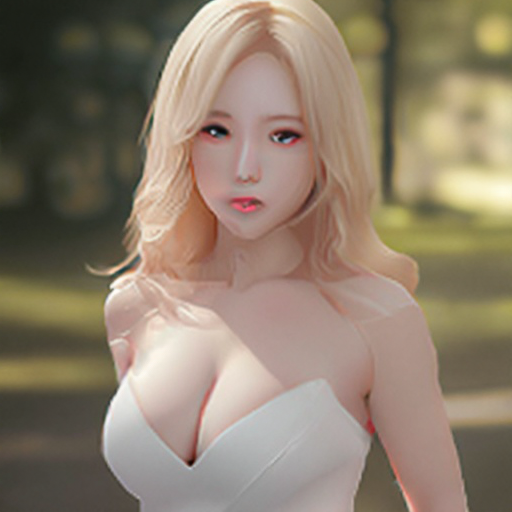

In [ ]:
#@title 创作--图片放大
# let's download an  image
url = "https://huggingface.co/datasets/hf-internal-testing/diffusers-images/resolve/main/sd2-upscale/low_res_cat.png"
url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"

low_res_img = download_image(url)
low_res_img = image1
low_res_img = low_res_img.resize((128, 128))

#prompt = "a white cat"
image_upscale = pipe_upscale(prompt=prompt, image=low_res_img).images[0]
image_upscale

In [ ]:
#@title 保存图片
#临时保存
import os
savepath = f"/content/output/"
if not os.path.exists(savepath):
  os.mkdir(savepath)
if not exist(n):
  n=1
image1.save(savepath+str(n)+".png")
n=n+1

In [1]:
#保存至google网盘
from google.colab import drive
drive.mount('/content/drive')

import os
savepath = f"/content/drive/MyDrive/output/images/"
if not os.path.exists(savepath):
  os.mkdir(savepath)
if not exist(n):
  n=1
image1.save(savepath+str(n)+".png")
n=n+1

MessageError: ignored

  0%|          | 0/30 [00:00<?, ?it/s]

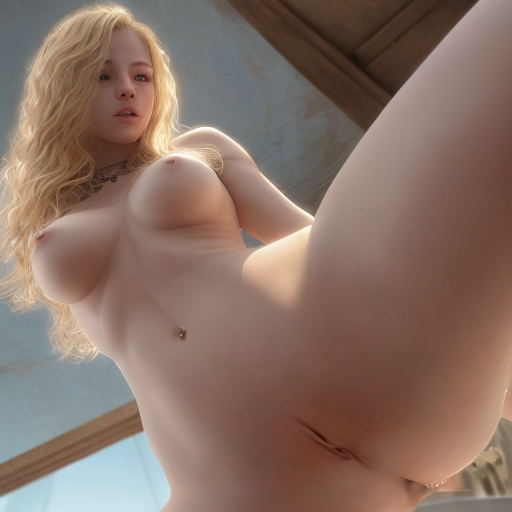

In [ ]:
#@title 用更多参数生成图像
import torch

generator = torch.Generator("cuda").manual_seed(1234)

image1 = pipe(prompt, num_inference_steps=1, guidance_scale=7, generator=generator).images[0]

image1

## **Prompt样例**
extremely detailed CG unity 8k wallpaper,(masterpiece),(best quality),(ultra detailed),(ultra realistic),(Best character details:1.36),nikon d750 f/1.4 55mm,dynamic angle,professional lighting, photon mapping, radiosity, physically-based rendering,
outdoors,looking at viewer,blush,(taut shirt), jeans,
1girl,(mature female:0.2),tall body,golden proportions,(Kpop idol),(shiny skin:1.2),(oil skin:1.1),makeup,[:(high detailed face:1.2):0.2]:, <lora:cuteGirlMix4_v10:0.8>, (close up), park, depth of field, <lora:seeThroughSilhouette_v10:0.5>,( closed mouth: 0.5)
((wavy gray hair and a sophisticated sense of style)),(aegyo sal:1),(puffy eyes),(eyelashes:1.1),(parted lips:1.1),red lipstick,wide shoulders

**Negative** prompt: Multiple people,More than one person,2girl,DeepNegative,
sketches,lowres,polar lowres,(worst quality:2),(low quality:2),(normal quality:2),((monochrome)),((grayscale)),blurry,cropped,mutation,deformed,text,error,signature,watermark,username,extra digit,fewer digits,jpeg artifacts,
skin spots, acnes, skin blemishes,
bad anatomy,bad anatomy,bad proportions,gross proportions,long neck,cross-eyed,malformed limbs,blurred hands,fused fingers,poorly drawn face,poorly drawn hands,
(mutated hands and fingers:1.3),(mutated legs and foots:1.3),bad body,bad limbs,bad arms,bad hands,bad fingers,bad leg,bad feet,missing limbs,missing arms,missing hands,missing fingers,missing legs,missing footextra limbs,extra arms,extra fingers,extra leg,extra foot,
Steps: 28, Sampler: DPM++ SDE Karras, CFG scale: 7.5, Seed: 1340860639, Face restoration: CodeFormer, Size: 640x960, Model hash: fc2511737a, Model: chilloutmix_NiPrunedFp32Fix, Denoising strength: 0.4, Hires upscale: 1.5, Hires steps: 30, Hires upscaler: Latent (bicubic antialiased)


Running the above cell multiple times will give you a different image every time. If you want deterministic output you can pass a random seed to the pipeline. Every time you use the same seed you'll have the same image result.

You can change the number of inference steps using the `num_inference_steps` argument. In general, results are better the more steps you use. Stable Diffusion, being one of the latest models, works great with a relatively small number of steps, so we recommend to use the default of `50`. If you want faster results you can use a smaller number.

The following cell uses the same seed as before, but with fewer steps. Note how some details, such as the horse's head or the helmet, are less defin realistic and less defined than in the previous image:

The other parameter in the pipeline call is `guidance_scale`. It is a way to increase the adherence to the conditional signal which in this case is text as well as overall sample quality. In simple terms classifier free guidance forces the generation to better match with the prompt. Numbers like `7` or `8.5` give good results, if you use a very large number the images might look good, but will be less diverse. 

You can learn about the technical details of this parameter in [the last section](https://colab.research.google.com/drive/1ALXuCM5iNnJDNW5vqBm5lCtUQtZJHN2f?authuser=1#scrollTo=UZp-ynZLrS-S) of this notebook.

To generate multiple images for the same prompt, we simply use a list with the same prompt repeated several times. We'll send the list to the pipeline instead of the string we used before.



Let's first write a helper function to display a grid of images. Just run the following cell to create the `image_grid` function, or disclose the code if you are interested in how it's done.

In [ ]:
from PIL import Image

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

Now, we can generate a grid image once having run the pipeline with a list of 3 prompts.

In [ ]:
num_images = 3
#prompt = ["a photograph of an astronaut riding a horse"] * num_images

images = pipe(prompt).images

grid = image_grid(images, rows=1, cols=3)
grid

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['extremely detailed, stamp, octane render,{{{ masterpiece }}}']


  0%|          | 0/50 [00:00<?, ?it/s]

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 6>:6                                                                              │
│ in image_grid:4                                                                                  │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AssertionError

And here's how to generate a grid of `n × m` images.

In [ ]:
num_cols = 2
num_rows = 1

# prompt = ["a photograph of an astronaut riding a horse"] * num_cols

all_images = []
for i in range(num_rows):
  images = pipe(prompt).images
  all_images.extend(images)

grid = image_grid(all_images, rows=num_rows, cols=num_cols)
grid

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['extremely detailed, stamp, octane render,{{{ masterpiece }}}']


  0%|          | 0/50 [00:00<?, ?it/s]

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 11>:11                                                                            │
│ in image_grid:4                                                                                  │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AssertionError

In [ ]:
image
grid = image_grid(all_images, rows=num_rows, cols=num_cols)
grid

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 2>:2                                                                              │
│ in image_grid:4                                                                                  │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AssertionError

### Generate non-square images

Stable Diffusion produces images of `512 × 512` pixels by default. But it's very easy to override the default using the `height` and `width` arguments, so you can create rectangular images in portrait or landscape ratios.

These are some recommendations to choose good image sizes:
- Make sure `height` and `width` are both multiples of `8`.
- Going below 512 might result in lower quality images.
- Going over 512 in both directions will repeat image areas (global coherence is lost).
- The best way to create non-square images is to use `512` in one dimension, and a value larger than that in the other one.

  0%|          | 0/50 [00:00<?, ?it/s]

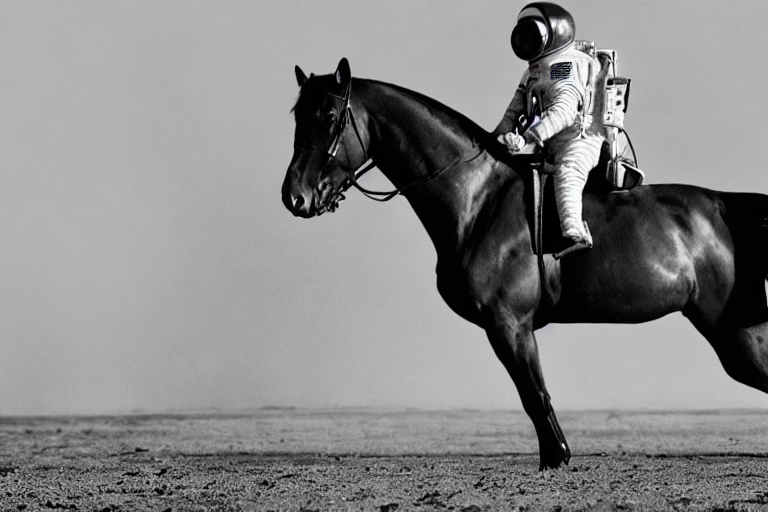

In [ ]:
prompt = "a photograph of an astronaut riding a horse"

image = pipe(prompt, height=512, width=768).images[0]
image

## 2. What is Stable Diffusion

Now, let's go into the theoretical part of Stable Diffusion 👩‍🎓.

Stable Diffusion is based on a particular type of diffusion model called **Latent Diffusion**, proposed in [High-Resolution Image Synthesis with Latent Diffusion Models](https://arxiv.org/abs/2112.10752).



General diffusion models are machine learning systems that are trained to *denoise* random gaussian noise step by step, to get to a sample of interest, such as an *image*. For a more detailed overview of how they work, check [this colab](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/diffusers_intro.ipynb).

Diffusion models have shown to achieve state-of-the-art results for generating image data. But one downside of diffusion models is that the reverse denoising process is slow. In addition, these models consume a lot of memory because they operate in pixel space, which becomes unreasonably expensive when generating high-resolution images. Therefore, it is challenging to train these models and also use them for inference.



<br>

Latent diffusion can reduce the memory and compute complexity by applying the diffusion process over a lower dimensional _latent_ space, instead of using the actual pixel space. This is the key difference between standard diffusion and latent diffusion models: **in latent diffusion the model is trained to generate latent (compressed) representations of the images.** 

There are three main components in latent diffusion.

1. An autoencoder (VAE).
2. A [U-Net](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/diffusers_intro.ipynb#scrollTo=wW8o1Wp0zRkq).
3. A text-encoder, *e.g.* [CLIP's Text Encoder](https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPTextModel).

**1. The autoencoder (VAE)**

The VAE model has two parts, an encoder and a decoder. The encoder is used to convert the image into a low dimensional latent representation, which will serve as the input to the *U-Net* model.
The decoder, conversely, transforms the latent representation back into an image.

 During latent diffusion _training_, the encoder is used to get the latent representations (_latents_) of the images for the forward diffusion process, which applies more and more noise at each step. During _inference_, the denoised latents generated by the reverse diffusion process are converted back into images using the VAE decoder. As we will see during inference we **only need the VAE decoder**.

**2. The U-Net**

The U-Net has an encoder part and a decoder part both comprised of ResNet blocks.
The encoder compresses an image representation into a lower resolution image representation and the decoder decodes the lower resolution image representation back to the original higher resolution image representation that is supposedly less noisy.
More specifically, the U-Net output predicts the noise residual which can be used to compute the predicted denoised image representation.

To prevent the U-Net from losing important information while downsampling, short-cut connections are usually added between the downsampling ResNets of the encoder to the upsampling ResNets of the decoder.
Additionally, the stable diffusion U-Net is able to condition its output on text-embeddings via cross-attention layers. The cross-attention layers are added to both the encoder and decoder part of the U-Net usually between ResNet blocks.

**3. The Text-encoder**

The text-encoder is responsible for transforming the input prompt, *e.g.* "An astronout riding a horse" into an embedding space that can be understood by the U-Net. It is usually a simple *transformer-based* encoder that maps a sequence of input tokens to a sequence of latent text-embeddings.

Inspired by [Imagen](https://imagen.research.google/), Stable Diffusion does **not** train the text-encoder during training and simply uses an CLIP's already trained text encoder, [CLIPTextModel](https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPTextModel).

**Why is latent diffusion fast and efficient?**

Since the U-Net of latent diffusion models operates on a low dimensional space, it greatly reduces the memory and compute requirements compared to pixel-space diffusion models. For example, the autoencoder used in Stable Diffusion has a reduction factor of 8. This means that an image of shape `(3, 512, 512)` becomes `(3, 64, 64)` in latent space, which requires `8 × 8 = 64` times less memory.

This is why it's possible to generate `512 × 512` images so quickly, even on 16GB Colab GPUs!

**Stable Diffusion during inference**

Putting it all together, let's now take a closer look at how the model works in inference by illustrating the logical flow.


<p align="left">
<img src="https://raw.githubusercontent.com/patrickvonplaten/scientific_images/master/stable_diffusion.png" alt="sd-pipeline" width="500"/>
</p>

The stable diffusion model takes both a latent seed and a text prompt as an input. The latent seed is then used to generate random latent image representations of size $64 \times 64$ where as the text prompt is transformed to text embeddings of size $77 \times 768$ via CLIP's text encoder.

Next the U-Net iteratively *denoises* the random latent image representations while being conditioned on the text embeddings. The output of the U-Net, being the noise residual, is used to compute a denoised latent image representation via a scheduler algorithm. Many different scheduler algorithms can be used for this computation, each having its pros and cons. For Stable Diffusion, we recommend using one of:

- [PNDM scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_pndm.py) (used by default).
- [K-LMS scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_lms_discrete.py).
- [Heun Discrete scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_heun_discrete.py).
- [DPM Solver Multistep scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_dpmsolver_multistep.py). This scheduler is able to achieve great quality in less steps. You can try with 25 instead of the default 50!

Theory on how the scheduler algorithm function is out of scope for this notebook, but in short one should remember that they compute the predicted denoised image representation from the previous noise representation and the predicted noise residual.
For more information, we recommend looking into [Elucidating the Design Space of Diffusion-Based Generative Models](https://arxiv.org/abs/2206.00364)

The *denoising* process is repeated *ca.* 50 times to step-by-step retrieve better latent image representations.
Once complete, the latent image representation is decoded by the decoder part of the variational auto encoder.



After this brief introduction to Latent and Stable Diffusion, let's see how to make advanced use of 🤗 Hugging Face Diffusers!

## 3. How to write your own inference pipeline with `diffusers`

Finally, we show how you can create custom diffusion pipelines with `diffusers`.
This is often very useful to dig a bit deeper into certain functionalities of the system and to potentially switch out certain components. 

In this section, we will demonstrate how to use Stable Diffusion with a different scheduler, namely [Katherine Crowson's](https://github.com/crowsonkb) K-LMS scheduler that was added in [this PR](https://github.com/huggingface/diffusers/pull/185#pullrequestreview-1074247365).

Let's go through the `StableDiffusionPipeline` step by step to see how we could have written it ourselves.

We will start by loading the individual models involved.

In [ ]:
import torch
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

The [pre-trained model](https://huggingface.co/CompVis/stable-diffusion-v1-3-diffusers/tree/main) includes all the components required to setup a complete diffusion pipeline. They are stored in the following folders:
- `text_encoder`: Stable Diffusion uses CLIP, but other diffusion models may use other encoders such as `BERT`.
- `tokenizer`. It must match the one used by the `text_encoder` model.
- `scheduler`: The scheduling algorithm used to progressively add noise to the image during training.
- `unet`: The model used to generate the latent representation of the input.
- `vae`: Autoencoder module that we'll use to decode latent representations into real images.

We can load the components by referring to the folder they were saved, using the `subfolder` argument to `from_pretrained`.

In [ ]:
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler

# 1. Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# 2. Load the tokenizer and text encoder to tokenize and encode the text. 
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# 3. The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

Now instead of loading the pre-defined scheduler, we'll use the K-LMS scheduler instead.

In [ ]:
from diffusers import LMSDiscreteScheduler

scheduler = LMSDiscreteScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

Downloading:   0%|          | 0.00/313 [00:00<?, ?B/s]

Next we move the models to the GPU.

In [ ]:
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device) 

We now define the parameters we'll use to generate images.

Note that `guidance_scale` is defined analog to the guidance weight `w` of equation (2) in the [Imagen paper](https://arxiv.org/pdf/2205.11487.pdf). `guidance_scale == 1` corresponds to doing no classifier-free guidance. Here we set it to 7.5 as also done previously.

In contrast to the previous examples, we set `num_inference_steps` to 100 to get an even more defined image.

In [ ]:
prompt = ["a photograph of an astronaut riding a horse"]

height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion

num_inference_steps = 100            # Number of denoising steps

guidance_scale = 7.5                # Scale for classifier-free guidance

generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise

batch_size = 1

First, we get the text_embeddings for the prompt. These embeddings will be used to condition the UNet model.

In [ ]:
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

with torch.no_grad():
  text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

We'll also get the unconditional text embeddings for classifier-free guidance, which are just the embeddings for the padding token (empty text). They need to have the same shape as the conditional `text_embeddings` (`batch_size` and `seq_length`)

In [ ]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]   

For classifier-free guidance, we need to do two forward passes. One with the conditioned input (`text_embeddings`), and another with the unconditional embeddings (`uncond_embeddings`). In practice, we can concatenate both into a single batch to avoid doing two forward passes.

In [ ]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

Generate the intial random noise.

In [ ]:
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)

In [ ]:
latents.shape

torch.Size([1, 4, 64, 64])

Cool $64 \times 64$ is expected. The model will transform this latent representation (pure noise) into a `512 × 512` image later on.

Next, we initialize the scheduler with our chosen `num_inference_steps`.
This will compute the `sigmas` and exact time step values to be used during the denoising process.

In [ ]:
scheduler.set_timesteps(num_inference_steps)

The K-LMS scheduler needs to multiply the `latents` by its `sigma` values. Let's do this here

In [ ]:
latents = latents * scheduler.init_noise_sigma

We are ready to write the denoising loop.

In [ ]:
from tqdm.auto import tqdm
from torch import autocast

for t in tqdm(scheduler.timesteps):
  # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
  latent_model_input = torch.cat([latents] * 2)

  latent_model_input = scheduler.scale_model_input(latent_model_input, t)

  # predict the noise residual
  with torch.no_grad():
    noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

  # perform guidance
  noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
  noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

  # compute the previous noisy sample x_t -> x_t-1
  latents = scheduler.step(noise_pred, t, latents).prev_sample

  0%|          | 0/100 [00:00<?, ?it/s]

We now use the `vae` to decode the generated `latents` back into the image.

In [ ]:
# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents

with torch.no_grad():
  image = vae.decode(latents).sample

And finally, let's convert the image to PIL so we can display or save it.

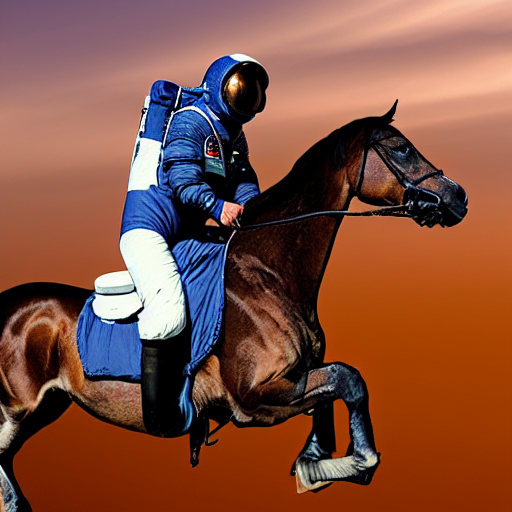

In [ ]:
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]

Now you have all the pieces to build your own pipelines or use diffusers components as you like 🔥.